# Transfer learning

We will load a pretrained version of `EfficientNet` [1], look at its feature maps, and apply it to a different task than originally trained on.

[1] https://arxiv.org/abs/1905.11946 

### Download a miniature version of image_net validation dataset:

Note: I got these from https://huggingface.co/datasets/imagenet-1k/tree/main

In [2]:
! curl -L --output imagenet_val.zip "https://www.dropbox.com/s/unc9g2tid4tyb8r/imagenet_val.zip?dl=1"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    61    0    61    0     0    109      0 --:--:-- --:--:-- --:--:--   111
100   323  100   323    0     0    285      0  0:00:01  0:00:01 --:--:--     0
100 62.7M  100 62.7M    0     0  4969k      0  0:00:12  0:00:12 --:--:-- 6329k3169k      0  0:00:20  0:00:04  0:00:16 5263k  0:00:06 5916k


In [ ]:
! unzip -o imagenet_val.zip

In [ ]:
import torch
from torchsummary import summary
import glob
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import torchvision.transforms as transforms
import torch.nn as nn

from classes import IMAGENET2012_CLASSES

In [2]:
%matplotlib inline

### Get the EfficientNet B6 model from torchvision

There are a lot of pretrained model weights out there!

In this case, we use a handy interface provided by `torchvision`

In [27]:
from torchvision import models

pretrained_weights = models.get_weight("EfficientNet_B6_Weights.IMAGENET1K_V1")
net = models.efficientnet_b6(weights=pretrained_weights)
net.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

--> See [EfficientNet_B6_Summary.txt](EfficientNet_B6_Summary.txt)

In [28]:
image_shape = (3, 256, 256)
summary(net,image_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 56, 128, 128]           1,512
       BatchNorm2d-2         [-1, 56, 128, 128]             112
              SiLU-3         [-1, 56, 128, 128]               0
            Conv2d-4         [-1, 56, 128, 128]             504
       BatchNorm2d-5         [-1, 56, 128, 128]             112
              SiLU-6         [-1, 56, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 56, 1, 1]               0
            Conv2d-8             [-1, 14, 1, 1]             798
              SiLU-9             [-1, 14, 1, 1]               0
           Conv2d-10             [-1, 56, 1, 1]             840
          Sigmoid-11             [-1, 56, 1, 1]               0
SqueezeExcitation-12         [-1, 56, 128, 128]               0
           Conv2d-13         [-1, 32, 128, 128]           1,792
      BatchNorm2d-14         [-1, 32, 1

--> See [EfficientNet_B6_Shape.txt](EfficientNet_B6_Shape.txt)

### We can create a batch of 1 random image and see what it predicts:

In [55]:
my_image = torch.rand(([1] + list(image_shape)))

In [56]:
raw_pred = net(my_image).detach()
probs = torch.nn.functional.softmax(raw_pred, dim=1)
pred = torch.argmax(probs,-1)[0].item()
pred_label = list(IMAGENET2012_CLASSES.values())[pred]

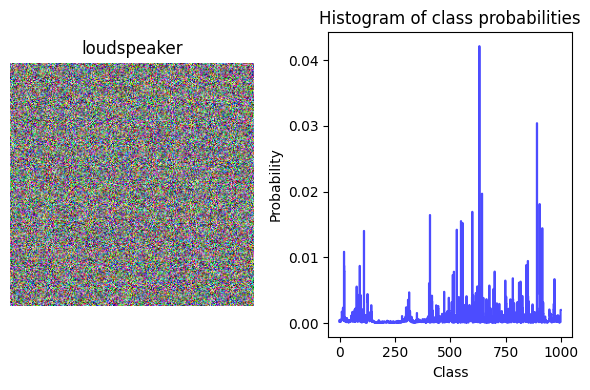

In [57]:
### plot the image with its predicted label along with a histogram of the classes
fig, axs = plt.subplots(1, 2, figsize=(6,4))
axs[0].imshow(my_image.squeeze(0).permute(1,2,0))
axs[0].set_title(pred_label.split(',')[0])
axs[0].axis('off')
axs[1].step(range(1000), probs.squeeze().tolist(), color='blue', alpha=0.7)
axs[1].set_title('Histogram of class probabilities')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Probability')
fig.tight_layout()
plt.show()

### Now let's use actual images from `IMAGENET`

In [58]:
images = glob.glob('imagenet_val/*.JPEG')
classes = [i.split('/')[-1].split('_')[-1].split('.')[0] for i in images]
labels = [IMAGENET2012_CLASSES[i] for i in classes]

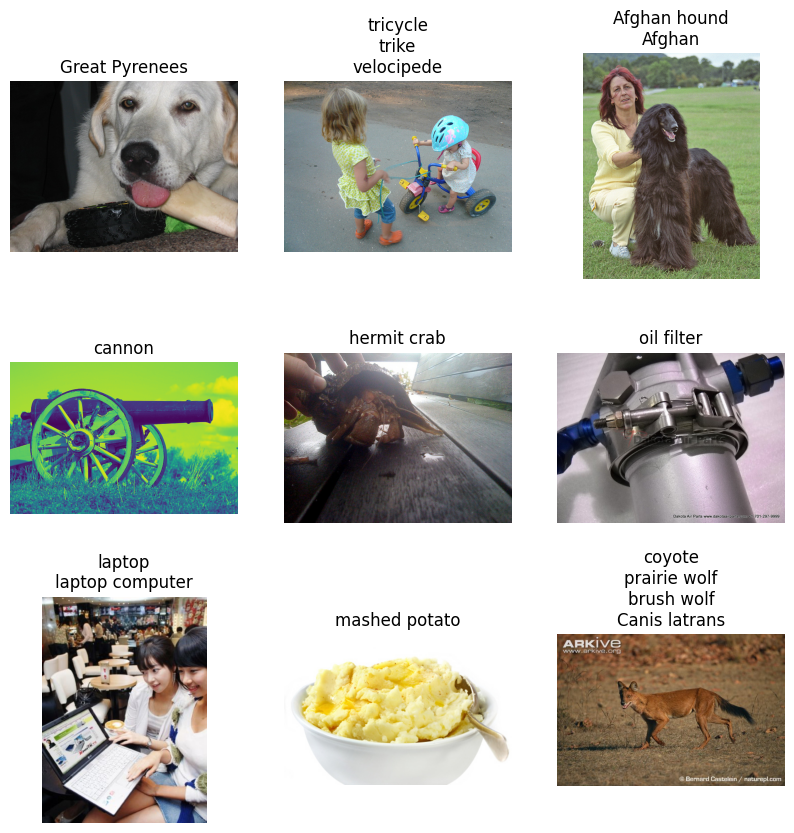

In [59]:
fig, ax = plt.subplots(3,3,figsize=(10,10))

for i in range(3):
    for j in range(3):
        index = random.randint(0,len(images)-1)
        img = Image.open(images[index])
        ax[i,j].imshow(img)
        title = labels[index].replace(', ','\n')
        ax[i,j].set_title(title)
        ax[i,j].axis('off')

plt.show()

### Pre-processing to be suitable for the network

In [60]:
def transform_image(path=None):

    ### pick a random example
    if path is None:
        images = glob.glob('imagenet_val/*.JPEG')
        image_index = random.randint(0,len(images)-1)
        path = images[image_index]

    ### load the image
    img = Image.open(path)

    ### create a torch tensor of the correct size 
    ### and use the normalization constants derived for the training dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(256),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225]),
    ])

    ### create a batch dimension
    img_tensor = transform(img).unsqueeze(0)
    return img, img_tensor


In [61]:
def predict_label(path=None):

    img, img_tensor = transform_image(path)

    predictions = net(img_tensor)
    predictions = torch.softmax(predictions, dim=1)

    ### get the top 3 predictions
    topN = 3
    scores, winners  = torch.sort(predictions, descending=True)
    winners = winners.flatten().tolist()[:topN]
    scores  = scores.flatten().tolist()[:topN]

    txt = ""
    for i, (winner, score) in enumerate(zip(winners, scores)):
        label_txt = list(IMAGENET2012_CLASSES.values())[winner]
        score_txt = f"{score*100:.2f}%"
        txt += f"{label_txt}, ({score_txt})"
        if i < topN - 1:
            txt += "\n"

    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(img)
    ax.set_title(txt)

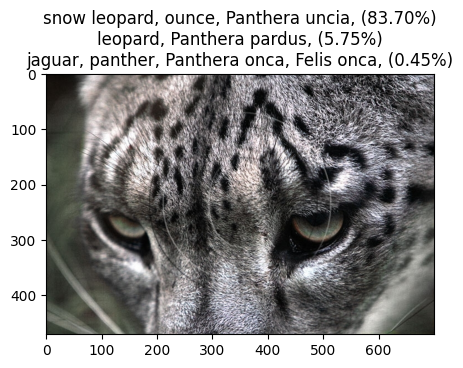

In [62]:
predict_label()

### Now let's try to visualize the learned feature maps

In [63]:
def get_feature_maps(net):

    maps = []

    ### walk through the network layers
    for layer in net.children():
        layer_type = str(type(layer))
        ### basic layer type
        if type(layer) == nn.Conv2d:
            maps.append(layer)
        else:
            ### nested layer type
            for nest in ['Conv2dNormActivation','Sequential','MBConv']:
                if nest in layer_type:
                    ### walk through the nested layer's children
                    for child in layer.children():
                        ### recursively call this function
                        maps += get_feature_maps(child)
    
    return maps

In [64]:
maps = get_feature_maps(net)
wgts = [m.weight.detach() for m in maps]

In [65]:
### The very first convolutional layer
maps[0]

Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [66]:
### The shape of the weights
wgts[0].shape

torch.Size([56, 3, 3, 3])

In [67]:
### Pass a single image through the first layer
random_img = transform_image()[1]
maps[0](random_img).shape

torch.Size([1, 56, 128, 128])

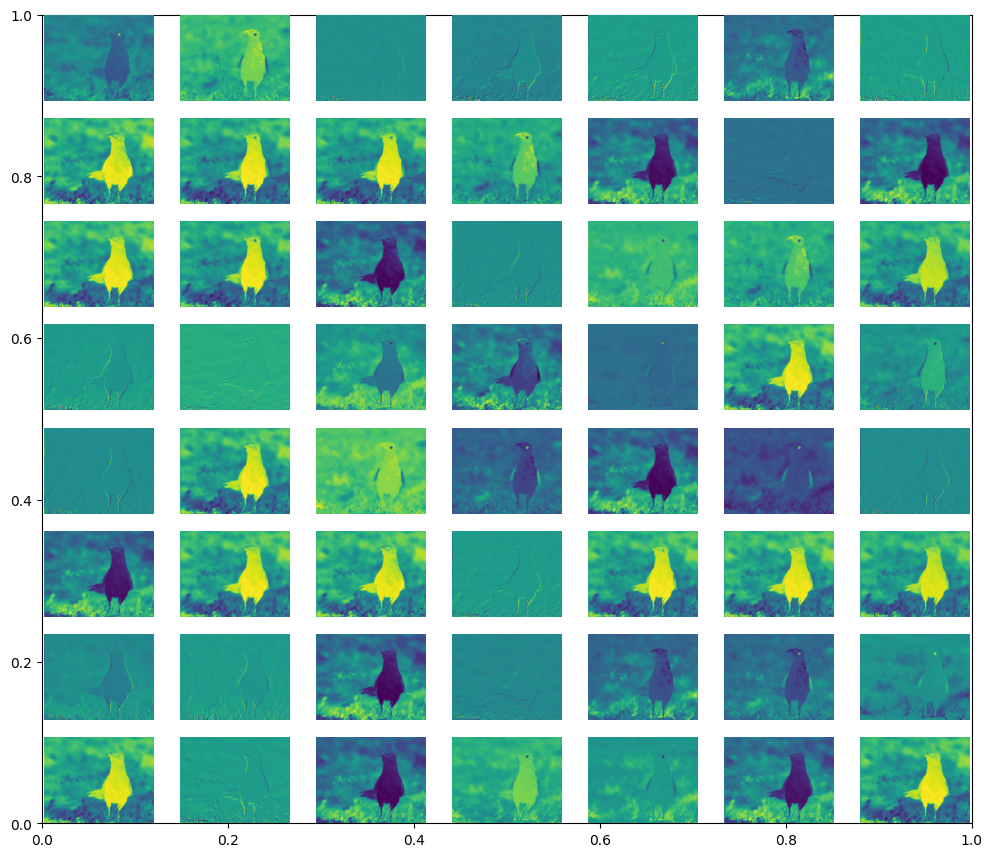

In [68]:
random_img, random_img_tensor = transform_image()
feats = maps[0](random_img_tensor).detach().squeeze(0)

Nrows=8
Ncols=len(feats)//Nrows

fig, ax = plt.subplots(figsize=(1.5*Nrows,1.5*Ncols))

for i, feat in enumerate(feats):
    fig.add_subplot(Nrows,Ncols,i+1)
    plt.imshow(feats[i])
    plt.axis('off')

plt.show()